# utilizzo di più istanze sugli algoritmi di clustering


## **Definizione delle funzioni e classi:**



In [53]:
# Libreries
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
from collections import defaultdict
import itertools
import time,random

In [54]:


def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show() 
        


# definizione della classe grafo
class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G


"""
Riempire i cluster in base al risultato di best_partition.
Se un nodo non è connesso a nessun altro nodo nel suo cluster designato, lo sposti in un altro cluster o ne crei uno nuovo.
Se ci sono troppi cluster, li unisci in base al numero di connessioni tra loro fino a raggiungere il numero desiderato di cluster.

"""


""" def divide_into_clusters(graph, k):
    partition = community_louvain.best_partition(graph)
    clusters = [[] for _ in range(k)]
    node_to_cluster = {}
    for node, cluster_index in partition.items():
        if len(clusters[cluster_index]) == 0 or any(graph.has_edge(node, n) for n in clusters[cluster_index]):
            clusters[cluster_index].append(node)
            node_to_cluster[node] = cluster_index
        else:
            # se il nodo non è connesso a nessun altro nodo nel cluster, cerca un altro cluster
            for new_cluster_index in range(k):
                if new_cluster_index != cluster_index and (len(clusters[new_cluster_index]) == 0 or any(graph.has_edge(node, n) for n in clusters[new_cluster_index])):
                    clusters[new_cluster_index].append(node)
                    node_to_cluster[node] = new_cluster_index
                    break
            else:
                # se non esiste un cluster adatto, crea uno nuovo
                clusters.append([node])
                node_to_cluster[node] = len(clusters) - 1

    # Unisci i cluster più piccoli fino a raggiungere il numero desiderato di cluster
    while len([c for c in clusters if c]) > k:
        # Trova il cluster più piccolo
        min_cluster_index = min(range(len(clusters)), key=lambda i: len(clusters[i]) if clusters[i] else float('inf'))
        min_cluster = clusters[min_cluster_index]
        clusters[min_cluster_index] = []
        # Trova il cluster con il maggior numero di connessioni con il cluster più piccolo
        connections = defaultdict(int)
        for node in min_cluster:
            for neighbor in graph.neighbors(node):
                if neighbor in node_to_cluster:
                    connections[node_to_cluster[neighbor]] += 1
        max_connections_index = max(connections, key=connections.get)
        # Unisci i due cluster
        clusters[max_connections_index].extend(min_cluster)
        for node in min_cluster:
            node_to_cluster[node] = max_connections_index

    return [c for c in clusters if c] """
    
    
def divide_into_clusters(graph, k):
    partition = community_louvain.best_partition(graph)
    
    if not partition:  # se la partizione è vuota
        return [list(graph.nodes())]  # restituisci un unico cluster con tutti i nodi

    max_partition_value = max(partition.values())

    
    # Assicuriamoci che la lista 'clusters' sia abbastanza grande
    clusters = [[] for _ in range(max_partition_value + 1)]
    node_to_cluster = {}

    for node, cluster_index in partition.items():
        if len(clusters[cluster_index]) == 0 or any(graph.has_edge(node, n) for n in clusters[cluster_index]):
            clusters[cluster_index].append(node)
            node_to_cluster[node] = cluster_index
        else:
            for new_cluster_index in range(len(clusters)):
                if new_cluster_index != cluster_index and (len(clusters[new_cluster_index]) == 0 or any(graph.has_edge(node, n) for n in clusters[new_cluster_index])):
                    clusters[new_cluster_index].append(node)
                    node_to_cluster[node] = new_cluster_index
                    break
            else:
                clusters.append([node])
                node_to_cluster[node] = len(clusters) - 1

    while len([c for c in clusters if c]) > k:
        min_cluster_index = min(range(len(clusters)), key=lambda i: len(clusters[i]) if clusters[i] else float('inf'))
        min_cluster = clusters[min_cluster_index]
        clusters[min_cluster_index] = []

        connections = defaultdict(int)
        for node in min_cluster:
            for neighbor in graph.neighbors(node):
                if neighbor in node_to_cluster:
                    connections[node_to_cluster[neighbor]] += 1

        max_connections_index = max(connections, key=connections.get)
        clusters[max_connections_index].extend(min_cluster)
        for node in min_cluster:
            node_to_cluster[node] = max_connections_index

    return [c for c in clusters if c]



def calculate_multicut_size(graph, clusters):
    multicut_size = 0
    for cluster in clusters:
        for node in cluster:
            for neighbor in graph.neighbors(node):
                if neighbor not in cluster:
                    multicut_size += 1
    # Poiché ogni arco viene contato due volte (una volta per ogni estremo), dividi per 2
    return multicut_size // 2

def check_solution(graph, clusters):
    total_nodes = sum(len(cluster) for cluster in clusters)
    if total_nodes != graph.number_of_nodes():
        print("Ogni nodo deve essere in un solo cluster.")
        return False

    for cluster in clusters:
        for node in cluster:
            node_neighbors = set(graph.neighbors(node))
            cluster_set = set(cluster)
            if not node_neighbors & cluster_set:
                print("Ogni nodo deve essere collegato in qualche modo ad un altro nodo del cluster.")
                return False

    multicut_size = calculate_multicut_size(graph, clusters)
    print("Dimensione del multi-cut:", multicut_size)

    print("La soluzione è ammissibile.")
    return True




In [55]:
def divide_into_clusters_greedy(graph, k):
    nodes = list(graph.nodes())
    clusters = [[node] for node in nodes]

    # Continua a unire i cluster finché non raggiungi il numero di cluster desiderato
    while len(clusters) > k:
        min_multicut_size = float('inf')
        cluster_to_merge_index = -1

        # Per ogni coppia di cluster, calcola la taglia del multicut se fossero uniti
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                new_cluster = clusters[i] + clusters[j]
                new_multicut_size = calcola_dimensione_multicut(graph, clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:])

                # Se unire questi due cluster produce la taglia di multicut più piccola finora, tieni traccia di essi
                if new_multicut_size < min_multicut_size:
                    min_multicut_size = new_multicut_size
                    cluster_to_merge_index = (i, j)

        # Unisci i due cluster che producono la taglia di multicut più piccola
        i, j = cluster_to_merge_index
        new_cluster = clusters[i] + clusters[j]
        clusters = clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:]

    return clusters

def è_ammissibile(grafo, clusters):
    for cluster in clusters:
        sottografo = grafo.subgraph(cluster)
        if not nx.is_connected(sottografo):
            return False
    return True

def calcola_dimensione_multicut(grafo, clusters):
    dimensione_multicut = 0
    for u, v in grafo.edges():
        if any(u in cluster and v in cluster for cluster in clusters):
            continue
        dimensione_multicut += 1  # o usa `grafo.edges[u, v]['weight']` se il grafo è pesato
    return dimensione_multicut

# Algoritmi genetici

Utilizzare gli algoritmi genetici (GA) per risolvere il problema di clustering può richiedere alcune decisioni di design:

- Codifica: come rappresentare una soluzione come un individuo in una popolazione.
- Funzione di fitness: come valutare la bontà di una soluzione.
- Selezione: come selezionare gli individui per la riproduzione.
- Crossover (ricombinazione): come combinare due individui per produrre un nuovo individuo.
- Mutazione: come introdurre piccole variazioni in un individuo.
  
Riorganizzando il codice per utilizzare gli algoritmi genetici:

- Codifica: ogni individuo è una lista di lunghezza uguale al numero di nodi nel grafo, dove l'elemento i-esimo rappresenta l'ID del cluster per il nodo i.

- Funzione di fitness: la funzione di fitness può essere basata sulla dimensione del multicut. Valori più bassi sono migliori.

- Selezione: utilizziamo la selezione della ruota della roulette.

- Crossover: utilizziamo un crossover a punto singolo.

- Mutazione: cambiamo l'ID del cluster di un nodo in modo casuale.

In [56]:
import random
def calcola_dimensione_multicut(grafo, clusters):
    dimensione_multicut = 0
    for u, v in grafo.edges():
        if any(u in cluster and v in cluster for cluster in clusters):
            continue
        dimensione_multicut += 1  # o usa `grafo.edges[u, v]['weight']` se il grafo è pesato
    return dimensione_multicut
def init_population(size, num_nodes, k):
    return [[random.randint(0, k-1) for _ in range(num_nodes)] for _ in range(size)]

def fitness(individual, graph):
    clusters = [[] for _ in range(max(individual) + 1)]
    for i, cluster_id in enumerate(individual):
        clusters[cluster_id].append(i)
    return calcola_dimensione_multicut(graph, clusters)

def roulette_wheel_selection(population, fitness_values):
    total_fit = sum(fitness_values)
    pick = random.uniform(0, total_fit)
    current = 0
    for ind, fit in zip(population, fitness_values):
        current += fit
        if current > pick:
            return ind


def crossover(parent1, parent2):
    idx = random.randint(0, len(parent1) - 1)
    child1 = parent1[:idx] + parent2[idx:]
    child2 = parent2[:idx] + parent1[idx:]
    return child1, child2

def mutate(individual, k):
    idx = random.randint(0, len(individual) - 1)
    individual[idx] = random.randint(0, k-1)

def genetic_algorithm(graph, k, pop_size=100, gen_count=1000, mutation_rate=0.01):
  
    # 1. Prima inizializza la popolazione
    population = init_population(pop_size, len(graph.nodes()), k)

    # 2. Poi calcola i fitness_values per questa popolazione iniziale
    fitness_values = [fitness(ind, graph) for ind in population]

    for gen in range(gen_count):
        new_population = []
        while len(new_population) < pop_size:
            parent1 = roulette_wheel_selection(population, fitness_values)
            parent2 = roulette_wheel_selection(population, fitness_values)
            child1, child2 = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                mutate(child1, k)
            if random.random() < mutation_rate:
                mutate(child2, k)
            new_population.extend([child1, child2])
        population = new_population
    
    best_individual = min(population, key=lambda ind: fitness(ind, graph))
    clusters = [[] for _ in range(max(best_individual) + 1)]
    for i, cluster_id in enumerate(best_individual):
        clusters[cluster_id].append(i)
    return clusters

## **Codice principale**

Tempo di esecuzione dell'algoritmo di Louvain: 0.0011210441589355469 secondi.
Tempo di esecuzione dell'algoritmo genetico: 0.769343376159668 secondi.


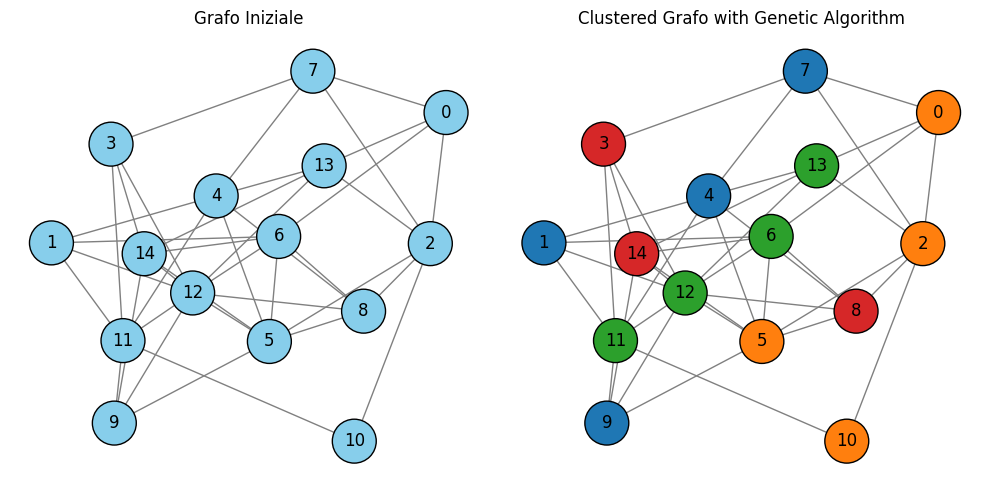

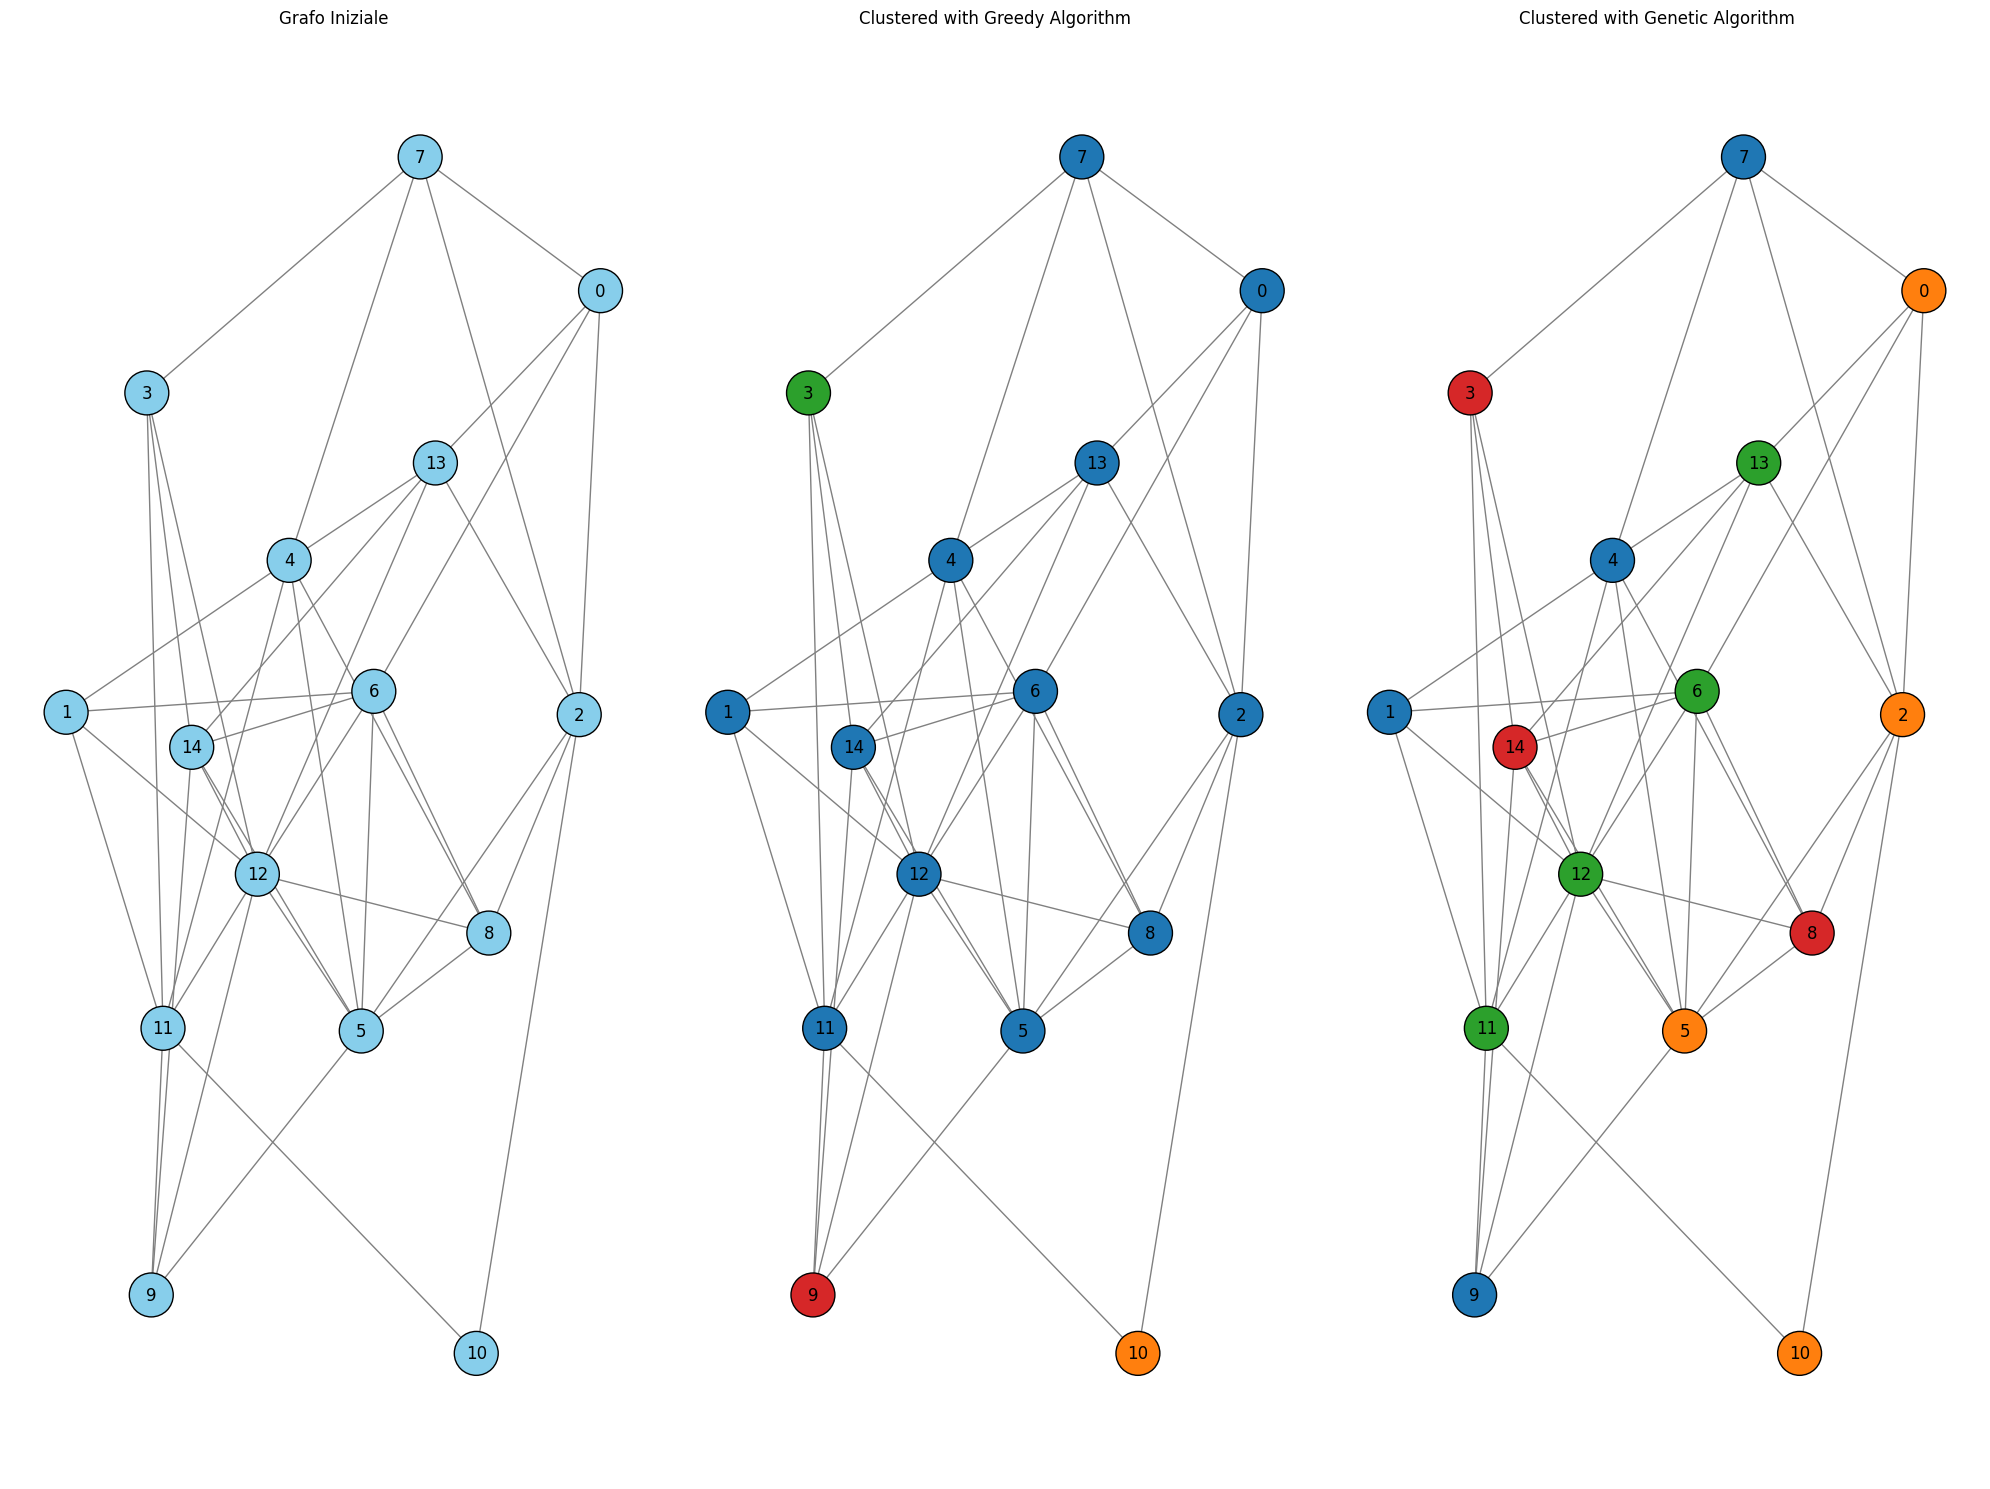

In [57]:
def generate_random_graph(n, p):
    """
    Genera un grafo casuale con n nodi e probabilità p di creare un arco.
    """
    grafo = Graph()
    for i in range(n):
        grafo.aggiungi_vertice(i)

    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < p:
                grafo.aggiungi_arco(i, j)
    return grafo



if __name__ == "__main__":
    random_graph = generate_random_graph(15, 0.3)
    G = converti_grafo_personalizzato_in_networkx(random_graph)

    plt.figure(figsize=(10, 5))

    # Visualizza il grafo iniziale
    plot_graph(G, "Grafo Iniziale",121)

    k = 4
    start_time = time.time()
    clusters = divide_into_clusters(G, k) # Presumibilmente, divide_into_clusters è un algoritmo di Louvain
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Tempo di esecuzione dell'algoritmo di Louvain: {elapsed_time} secondi.")
    
    start_time = time.time()
    clusters_genetic = genetic_algorithm(G, k)
    end_time = time.time()
    elapsed_time_genetic = end_time - start_time
    print(f"Tempo di esecuzione dell'algoritmo genetico: {elapsed_time_genetic} secondi.")

    plot_graph(G, "Clustered Grafo with Genetic Algorithm", 122, colors=clusters_genetic)

    plt.tight_layout()
    plt.savefig("grafo.png")
    plt.show()

    plt.figure(figsize=(20, 15))
    
    # Visualizza il grafo iniziale
    plot_graph(G, "Grafo Iniziale", 131)

    # Utilizza l'algoritmo Greedy
    clusters_greedy = divide_into_clusters_greedy(G, 4)
    plot_graph(G, "Clustered with Greedy Algorithm", 132, colors=clusters_greedy)

    # Utilizza l'algoritmo Genetico (già fatto in precedenza)
    plot_graph(G, "Clustered with Genetic Algorithm", 133, colors=clusters_genetic)

    plt.tight_layout()
    plt.savefig("comparison.png")
    plt.show()